# Unsloth on DGX Spark

First we take care of determinism setting all the seeds globaly 

In [1]:
import random

import numpy as np
import torch

SEED = 3407


random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

We import needed functions - including unsloth - for auto-patching

In [ ]:

from unsloth import FastLanguageModel, FastModel
from unsloth.chat_templates import get_chat_template, standardize_sharegpt
import torch
from datasets import load_dataset
from transformers import TextStreamer
from trl import SFTConfig, SFTTrainer

max_seq_length = 2048
model_name="unsloth/Meta-Llama-3.1-8B-Instruct"
chat_template="llama-3.1"
dataset="mlabonne/FineTome-100k"
is_moe = False
loader = FastLanguageModel
if is_moe:
    loader=FastModel

## Model

Load Llama-3.1-8B-Instruct model as 4bit (QLoRA)

In [3]:
model, tokenizer = loader.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    cache_dir="./model",
)

==((====))==  Unsloth 2025.10.10: Fast Qwen3_Moe patching. Transformers: 4.56.2.
   \\   /|    NVIDIA GB10. Num GPUs = 1. Max memory: 119.699 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0a0+145a3a7bda.nv25.10. CUDA: 12.1. CUDA Toolkit: 13.0. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33+c2407a6.d20251029. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/16 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Prepare QLoRA layers

In [ ]:
peft_model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
    ],
    random_state=SEED,
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    max_seq_length=max_seq_length,
    use_rslora=False,
    loftq_config=None,
)

## Data

Prepare tokenizer with propper chat template, and create function for data mapping

In [ ]:
inference_tokenizer = get_chat_template(
    tokenizer,
    chat_template=chat_template,
)


def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [
        inference_tokenizer.apply_chat_template(
            convo, tokenize=False, add_generation_prompt=True
        )
        for convo in convos
    ]
    return {
        "text": texts,
    }

Load FineTome datase

In [ ]:
dataset = load_dataset(dataset, split="train")

Format it to llama-3.1 format

In [ ]:
dataset = standardize_sharegpt(dataset)
formated_dataset = dataset.map(
    formatting_prompts_func,
    batched=True,
)

In [ ]:
formated_dataset[5]["text"]

## Training

In [ ]:


trainer = SFTTrainer(
    model=peft_model,
    train_dataset=formated_dataset,
    tokenizer=tokenizer,
    dataset_text_field="text",
    args=SFTConfig(
        max_seq_length=max_seq_length,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=16,
        warmup_steps=10,
        num_train_epochs=1,
        logging_steps=1,
        output_dir="outputs",
        optim="adamw_8bit",
        seed=SEED,
        report_to="wandb",
    ),
)

In [ ]:
trainer.train()

## Manual test

In [ ]:
inference_model = FastLanguageModel.for_inference(peft_model)

In [ ]:
messages = [
    {
        "role": "user",
        "content": "How does the Earth's tilt affect the amount and intensity of sunlight received at different latitudes?",
    },
]
print(
    inference_tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
)

In [ ]:
inputs = inference_tokenizer.apply_chat_template(
    messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
).to("cuda")

text_streamer = TextStreamer(tokenizer)
_ = inference_model.generate(
    input_ids=inputs, streamer=text_streamer, max_new_tokens=1024, use_cache=True
)

### Note
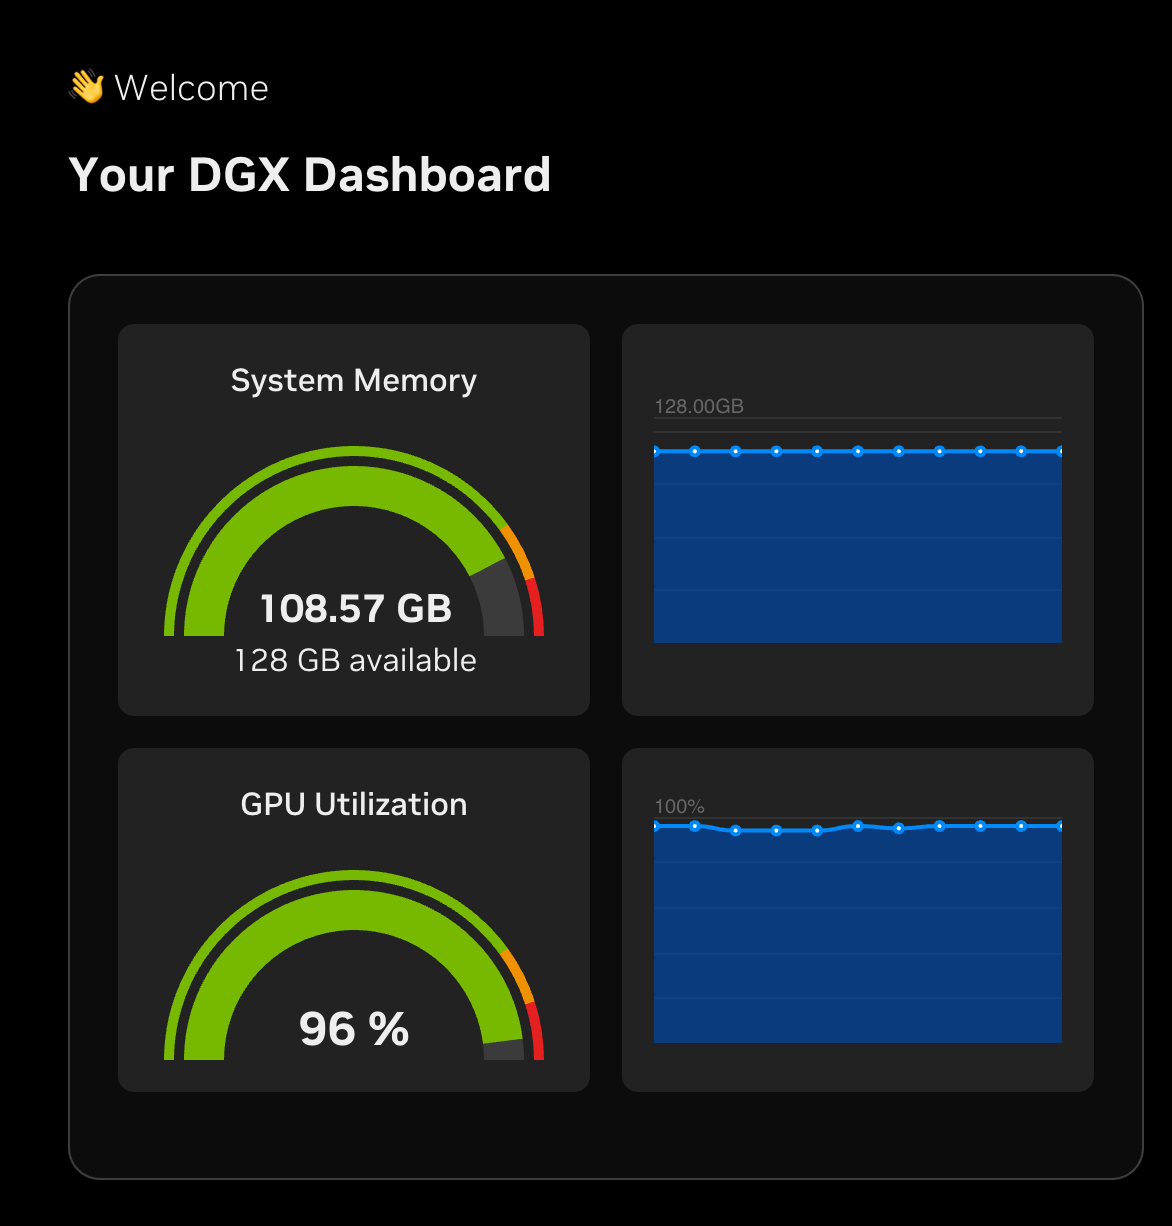
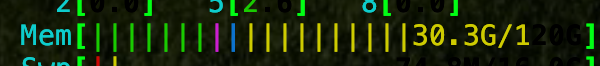


DGX Dashboard is showing not fully correct memory ussage - as it includes system caches